In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import pickle
import h5py
from sklearn.preprocessing import StandardScaler
%matplotlib inline

import tensorflow as tf
import keras
import keras.layers as L
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.core import Flatten, Dropout
from keras.layers import Input, merge
from keras.layers.pooling import MaxPooling2D
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Model
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.advanced_activations import LeakyReLU
from keras.models import load_model,Sequential
import keras.backend as K
from keras.initializers import RandomNormal

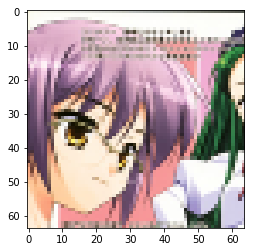

In [0]:
arr = cv2.imread("/content/drive/My Drive/AnimeCharacterDataset/data/face_0_119_15.png")
arr = cv2.cvtColor(arr, cv2.COLOR_BGR2RGB)
arr = cv2.resize(arr,(64,64)) 
X_train=np.vstack([arr[np.newaxis,...]])
plt.imshow(X_train[0])

In [0]:
for img in os.listdir("/content/drive/My Drive/AnimeCharacterDataset/data"):
    arr = cv2.imread("/content/drive/My Drive/AnimeCharacterDataset/data/"+str(img))
    arr = cv2.cvtColor(arr, cv2.COLOR_BGR2RGB)
    arr = cv2.resize(arr,(64,64))
    X_train=np.vstack([X_train,arr[np.newaxis,...] ])

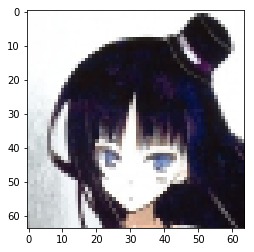

In [39]:
plt.imshow(X_train[18])

In [0]:
with open("/content/drive/My Drive/AnimeCharacterDataset/real_data.pkl","rb") as f:
    X_train = pickle.load(f)

In [0]:
X_train = X_train/255.0

In [40]:
s=tf.InteractiveSession()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [18]:
gen_model = Sequential()

gen_model.add(Dense(input_dim=100, output_dim=2048))
gen_model.add(LeakyReLU(alpha=0.2))

gen_model.add(Dense(256 * 8 * 8))
gen_model.add(BatchNormalization())
gen_model.add(LeakyReLU(alpha=0.2))

gen_model.add(Reshape((8, 8, 256), input_shape=(256 * 8 * 8,)))
gen_model.add(UpSampling2D(size=(2, 2)))

gen_model.add(Conv2D(128, (5, 5), padding='same'))
gen_model.add(LeakyReLU(alpha=0.2))

gen_model.add(UpSampling2D(size=(2, 2)))

gen_model.add(Conv2D(64, (5, 5), padding='same'))
gen_model.add(LeakyReLU(alpha=0.2))

gen_model.add(UpSampling2D(size=(2, 2)))

gen_model.add(Conv2D(3, (5, 5), padding='same'))
gen_model.add(LeakyReLU(alpha=0.2))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=100, units=2048)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
gen_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 2048)              206848    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 16384)             33570816  
_________________________________________________________________
batch_normalization_2 (Batch (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 16, 16, 256)      

In [0]:
dis_model = Sequential()

dis_model.add(Conv2D(128, (5, 5),padding='same',input_shape=(64, 64, 3)))
dis_model.add(LeakyReLU(alpha=0.2))
dis_model.add(MaxPooling2D(pool_size=(2, 2)))

dis_model.add(Conv2D(256, (3, 3)))
dis_model.add(LeakyReLU(alpha=0.2))
dis_model.add(MaxPooling2D(pool_size=(2, 2)))

dis_model.add(Conv2D(512, (3, 3)))
dis_model.add(LeakyReLU(alpha=0.2))
dis_model.add(MaxPooling2D(pool_size=(2, 2)))

dis_model.add(Flatten())
dis_model.add(Dense(1024))
dis_model.add(LeakyReLU(alpha=0.2))

dis_model.add(L.Dense(2,activation=tf.nn.log_softmax))

In [21]:
dis_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 64, 64, 128)       9728      
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 64, 64, 128)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 30, 30, 256)       295168    
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 30, 30, 256)       0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 256)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 13, 13, 512)      

In [0]:
IMG_SHAPE = X_train.shape[1:]
CODE_SIZE = 100

noise = tf.placeholder('float32',[None,CODE_SIZE])
real_data = tf.placeholder('float32',[None,]+list(IMG_SHAPE))

logp_real = dis_model(real_data)

generated_data = gen_model(noise)

logp_gen = dis_model(generated_data)


In [0]:
##discriminator training##

d_loss = -tf.reduce_mean(logp_real[:,1] + logp_gen[:,0])
  
#regularize
d_loss += tf.reduce_mean(dis_model.layers[-1].kernel**2)

#optimize
disc_optimizer = tf.train.GradientDescentOptimizer(1e-3).minimize(d_loss,var_list=dis_model.trainable_weights)

In [0]:
##generator training##

g_loss = -tf.reduce_mean(1-logp_gen[:,0])

gen_optimizer = tf.train.AdamOptimizer(1e-4).minimize(g_loss,var_list=gen_model.trainable_weights)    

In [0]:
s.run(tf.global_variables_initializer())

In [0]:
total_epoch = 20000

def sample_noise_batch(bsize):
    return np.random.normal(size=(bsize, 100)).astype('float32')

def sample_data_batch(bsize):
    idxs = np.random.choice(np.arange(X_train.shape[0]), size=bsize)
    return X_train[idxs]

In [0]:
def sample_images(nrow,ncol, sharp=False):
    images = gen_model.predict(sample_noise_batch(bsize=nrow*ncol))
    if np.var(images)!=0:
        images = images.clip(np.min(X_train),np.max(X_train))
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray")
    plt.show()

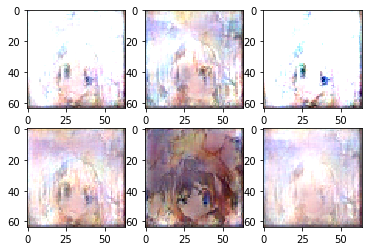

In [0]:
from IPython import display

for epoch in range(total_epoch):
    feed_dict={
        real_data: sample_data_batch(100),
        noise: sample_noise_batch(100)
    }
    
    for i in range(5):
        s.run(disc_optimizer,feed_dict)
    
    s.run(gen_optimizer,feed_dict)
    
    if epoch%100==0:
        display.clear_output(wait=True)
        sample_images(2,3,True)

In [0]:
gen_model.save("gen_model.h5")
dis_model.save("dis_model.h5")